<a href="https://colab.research.google.com/github/DanielWill-1/bayesian-network-project/blob/main/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Imports for PyTorch and model evaluation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Disable MLflow UI and Prometheus for Colab compatibility
# Adjusting the script to focus on essential functionalities.

# Load the dataset
from google.colab import files

print("Please upload the weatherAUS.csv file.")


data = pd.read_csv('weatherAUS.csv')

# Data Preprocessing
# ==================

# Select relevant columns
data = data[['Location', 'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Rainfall']]

# Handle missing values by dropping rows with NaNs
data.dropna(inplace=True)

# Average MinTemp and MaxTemp to get a general Temperature
data['Temperature'] = data[['MinTemp', 'MaxTemp']].mean(axis=1)

# Average Humidity9am and Humidity3pm to get a general Humidity
data['Humidity'] = data[['Humidity9am', 'Humidity3pm']].mean(axis=1)

# Use Rainfall as Precipitation
data['Precipitation'] = data['Rainfall']

# Select the new columns
data = data[['Location', 'Temperature', 'Humidity', 'Precipitation']]

# Discretize continuous variables using quantiles
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing")

continuous_vars = ['Temperature', 'Humidity', 'Precipitation']
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data[continuous_vars] = est.fit_transform(data[continuous_vars])

# Encode categorical variables
location_encoder = LabelEncoder()
data['Location_encoded'] = location_encoder.fit_transform(data['Location'])

# Update data to use encoded location
data_model = data[['Location_encoded', 'Temperature', 'Humidity', 'Precipitation']]

# Bayesian Network Structure Learning
# ===================================
hc = HillClimbSearch(data_model)
best_model = hc.estimate(scoring_method=BicScore(data_model))

# Create the Bayesian Model with the learned structure
model = BayesianModel(best_model.edges())

# Estimate the Conditional Probability Distributions (CPDs)
model.fit(data_model, estimator=MaximumLikelihoodEstimator)

# Perform inference with the model
infer = VariableElimination(model)

# User Interaction for Location Input
# ====================================

while True:
    user_location = input("\nEnter a location (e.g., Sydney): ")

    # Check if the entered location exists in the dataset
    if user_location in location_encoder.classes_:
        break
    else:
        print(f"Location '{user_location}' not found in the dataset.")
        print("Available locations are:", list(location_encoder.classes_))
        print("Please try again.")

# Encode the location
encoded_location = location_encoder.transform([user_location])[0]

# Optional: Ask for Temperature bin
temperature_bin = input("\nEnter Temperature bin (0: Low, 1: Medium, 2: High, leave blank if unknown): ")
if temperature_bin == '':
    # If temperature is unknown, we don't set it in evidence
    evidence = {'Location_encoded': encoded_location}
else:
    try:
        temperature_bin = int(temperature_bin)
        evidence = {'Location_encoded': encoded_location, 'Temperature': temperature_bin}
    except ValueError:
        print("Invalid Temperature bin. Using default evidence.")
        evidence = {'Location_encoded': encoded_location}

# Predict Humidity
q_humidity = infer.query(variables=['Humidity'], evidence=evidence)

# Predict Precipitation
q_precipitation = infer.query(variables=['Precipitation'], evidence=evidence)

# Display Predictions
print("\nPredicted Humidity given evidence:")
for idx, prob in enumerate(q_humidity.values):
    print(f"Humidity bin {idx}: Probability = {prob:.4f}")

print("\nPredicted Precipitation given evidence:")
for idx, prob in enumerate(q_precipitation.values):
    print(f"Precipitation bin {idx}: Probability = {prob:.4f}")


Please upload the weatherAUS.csv file.


<ipython-input-9-730235bee609>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
<ipython-input-9-730235bee609>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Temperature'] = data[['MinTemp', 'MaxTemp']].mean(axis=1)
<ipython-input-9-730235bee609>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

  0%|          | 0/1000000 [00:00<?, ?it/s]


Enter a location (e.g., Sydney): Sydney

Enter Temperature bin (0: Low, 1: Medium, 2: High, leave blank if unknown): 



Predicted Humidity given evidence:
Humidity bin 0: Probability = 0.0000
Humidity bin 1: Probability = 0.0021
Humidity bin 2: Probability = 0.0166
Humidity bin 3: Probability = 0.0556
Humidity bin 4: Probability = 0.1291
Humidity bin 5: Probability = 0.2246
Humidity bin 6: Probability = 0.2857
Humidity bin 7: Probability = 0.1904
Humidity bin 8: Probability = 0.0762
Humidity bin 9: Probability = 0.0196

Predicted Precipitation given evidence:
Precipitation bin 0: Probability = 0.9918
Precipitation bin 1: Probability = 0.0064
Precipitation bin 2: Probability = 0.0012
Precipitation bin 3: Probability = 0.0003
Precipitation bin 4: Probability = 0.0002
Precipitation bin 5: Probability = 0.0000
Precipitation bin 6: Probability = 0.0000
Precipitation bin 7: Probability = 0.0000
Precipitation bin 8: Probability = 0.0000


<ipython-input-11-1889fd7c9820>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[continuous_vars] = est.fit_transform(data[continuous_vars])
<ipython-input-11-1889fd7c9820>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[continuous_vars] = data[continuous_vars].astype(int)
<ipython-input-11-1889fd7c9820>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

  0%|          | 0/1000000 [00:00<?, ?it/s]

Enter a location (e.g., Sydney): Sydney
Enter Temperature bin (0: Low, 1: Medium, 2: High, leave blank if unknown): 



Predicted Humidity given evidence:
Humidity bin 0 (approx. 0.0% - 53.5%): Probability = 0.2645
Humidity bin 1 (approx. 53.5% - 69.0%): Probability = 0.4235
Humidity bin 2 (approx. 69.0% - 100.0%): Probability = 0.3120

Predicted Precipitation given evidence:
Precipitation bin 0 (approx. 0.0mm - 0.2mm): Probability = 0.6058
Precipitation bin 1 (approx. 0.2mm - 371.0mm): Probability = 0.3942

Expected Rainfall Amount: 73.22 mm


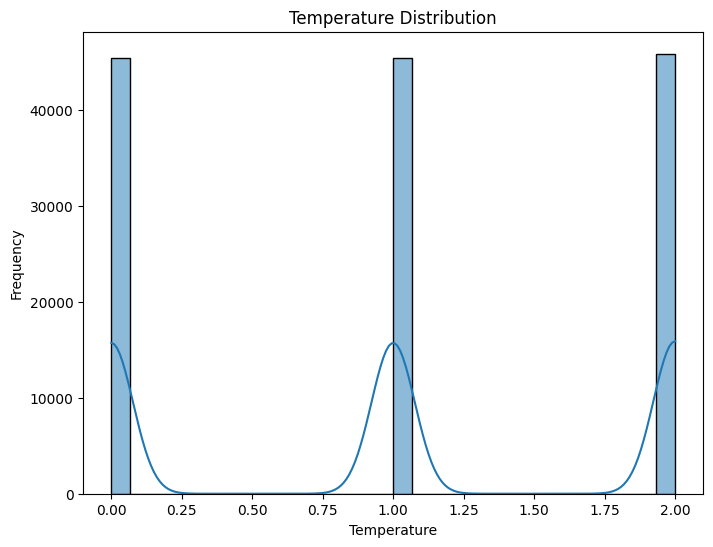

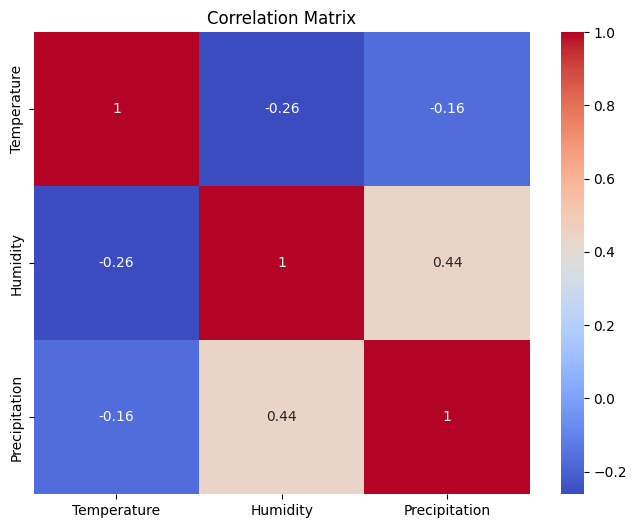

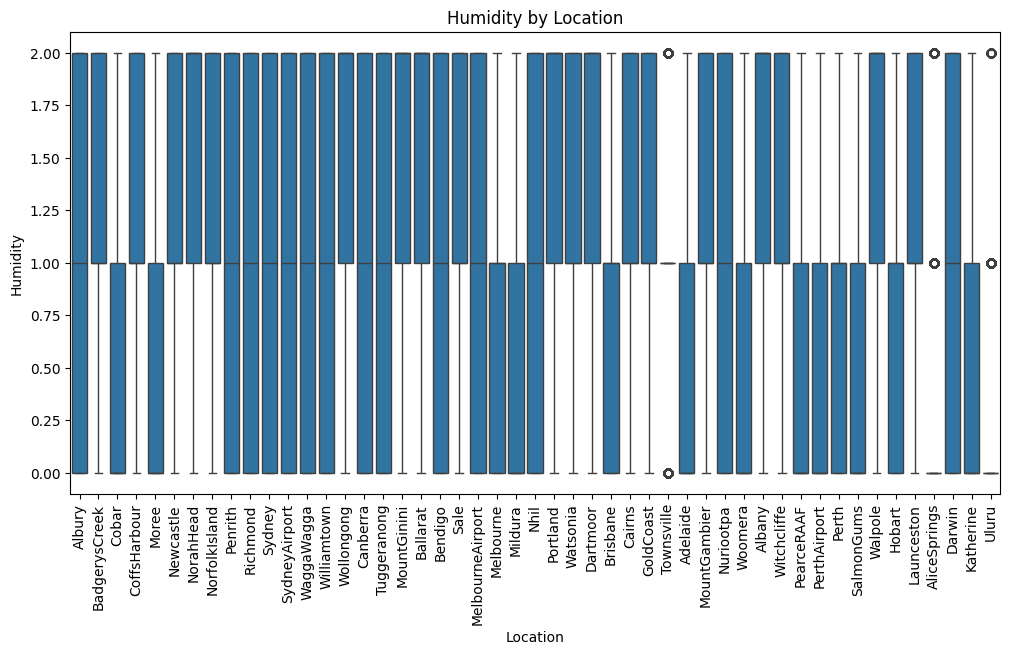

<ipython-input-11-1889fd7c9820>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_continuous['Location_encoded'] = le_location.fit_transform(data_continuous['Location'])



Training model for Humidity prediction...
Hidden Size: 16, Learning Rate: 0.001, Avg MSE: 0.8161
Hidden Size: 16, Learning Rate: 0.01, Avg MSE: 0.8121
Hidden Size: 32, Learning Rate: 0.001, Avg MSE: 0.8011
Hidden Size: 32, Learning Rate: 0.01, Avg MSE: 0.8099
Best Params: {'hidden_size': 32, 'learning_rate': 0.001}, Best Score: 0.8011

Training model for Precipitation prediction...
Hidden Size: 16, Learning Rate: 0.001, Avg MSE: 0.9906
Hidden Size: 16, Learning Rate: 0.01, Avg MSE: 0.9930
Hidden Size: 32, Learning Rate: 0.001, Avg MSE: 0.9879
Hidden Size: 32, Learning Rate: 0.01, Avg MSE: 0.9930
Best Params: {'hidden_size': 32, 'learning_rate': 0.001}, Best Score: 0.9879

Training final model for Humidity prediction...
Epoch 1/20, Loss: 0.8490
Epoch 2/20, Loss: 0.8325
Epoch 3/20, Loss: 0.8280
Epoch 4/20, Loss: 0.8245
Epoch 5/20, Loss: 0.8214
Epoch 6/20, Loss: 0.8186
Epoch 7/20, Loss: 0.8155
Epoch 8/20, Loss: 0.8124
Epoch 9/20, Loss: 0.8099
Epoch 10/20, Loss: 0.8082
Epoch 11/20, Loss: 

<ipython-input-11-1889fd7c9820>:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_humidity.load_state_dict(torch.load('model_humidity.pth'))
<ipython-input-11-1889fd7

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
# New imports for PyTorch and model evaluation (Step 5)
# -----------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
# -----------------------------------------------------
# Load the dataset
# Ensure that the 'weatherAUS.csv' file is in your working directory
data = pd.read_csv('weatherAUS.csv')
# Data Preprocessing
# Select relevant columns
data = data[['Location', 'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Rainfall']]
# Handle missing values by dropping rows with NaNs
data.dropna(inplace=True)
# Average MinTemp and MaxTemp to get a general Temperature
data['Temperature'] = data[['MinTemp', 'MaxTemp']].mean(axis=1)
# Average Humidity9am and Humidity3pm to get a general Humidity
data['Humidity'] = data[['Humidity9am', 'Humidity3pm']].mean(axis=1)
# Use Rainfall as Precipitation
data['Precipitation'] = data['Rainfall']
# Select the new columns
data = data[['Location', 'Temperature', 'Humidity', 'Precipitation']]
# Discretize continuous variables using quantiles
from sklearn.preprocessing import KBinsDiscretizer
continuous_vars = ['Temperature', 'Humidity', 'Precipitation']
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data[continuous_vars] = est.fit_transform(data[continuous_vars])
data[continuous_vars] = data[continuous_vars].astype(int)
from sklearn.preprocessing import LabelEncoder
location_encoder = LabelEncoder()
data['Location_encoded'] = location_encoder.fit_transform(data['Location'])
# Update data to use encoded location
data_model = data[['Location_encoded', 'Temperature', 'Humidity', 'Precipitation']]
# Bayesian Network Structure Learning
hc = HillClimbSearch(data_model)  # Remove scoring_method from here
best_model = hc.estimate(scoring_method=BicScore(data_model))  # Pass scoring_method to estimate()
# Create the Bayesian Model with the learned structure
model = BayesianModel(best_model.edges())
# Estimate the Conditional Probability Distributions (CPDs)
model.fit(data_model, estimator=MaximumLikelihoodEstimator)
# Perform inference with the model
infer = VariableElimination(model)
# Allow the user to input a location
user_location = input("Enter a location (e.g., Sydney): ")
# Check if the entered location exists in the dataset
if user_location not in location_encoder.classes_:
    print(f"Location '{user_location}' not found in the dataset.")
    print("Available locations are:", list(location_encoder.classes_))
else:
    # Get the encoded value of the location
    encoded_location = location_encoder.transform([user_location])[0]
    # Optionally, you can ask the user to input Temperature or use default
    # For simplicity, let's ask for Temperature bin
    temperature_bin = input("Enter Temperature bin (0: Low, 1: Medium, 2: High, leave blank if unknown): ")
    if temperature_bin == '':
        # If temperature is unknown, we don't set it in evidence
        evidence = {'Location_encoded': encoded_location}
    else:
        try:
            temperature_bin = int(temperature_bin)
            if temperature_bin not in [0, 1, 2]:
                raise ValueError
            evidence = {'Location_encoded': encoded_location, 'Temperature': temperature_bin}
        except ValueError:
            print("Invalid Temperature bin. Please enter 0, 1, or 2.")
            exit()
    # Predict Humidity
    q_humidity = infer.query(variables=['Humidity'], evidence=evidence)
    # Predict Precipitation
    q_precipitation = infer.query(variables=['Precipitation'], evidence=evidence)
    # Map the bins back to approximate ranges
    # Get the bin edges for Precipitation
    precipitation_bin_edges = est.bin_edges_[continuous_vars.index('Precipitation')]
    # Calculate expected rainfall amount
    expected_rainfall = 0
    for bin_idx in range(len(q_precipitation.values)):
        # Calculate the midpoint of the bin
        bin_start = precipitation_bin_edges[bin_idx]
        bin_end = precipitation_bin_edges[bin_idx + 1]
        bin_midpoint = (bin_start + bin_end) / 2
        # Multiply by the probability
        expected_rainfall += bin_midpoint * q_precipitation.values[bin_idx]
    # Output the predictions
    print("\nPredicted Humidity given evidence:")
    for idx, prob in enumerate(q_humidity.values):
        print(f"Humidity bin {idx} (approx. {est.bin_edges_[continuous_vars.index('Humidity')][idx]:.1f}% - {est.bin_edges_[continuous_vars.index('Humidity')][idx+1]:.1f}%): Probability = {prob:.4f}")
    print("\nPredicted Precipitation given evidence:")
    for idx, prob in enumerate(q_precipitation.values):
        print(f"Precipitation bin {idx} (approx. {est.bin_edges_[continuous_vars.index('Precipitation')][idx]:.1f}mm - {est.bin_edges_[continuous_vars.index('Precipitation')][idx+1]:.1f}mm): Probability = {prob:.4f}")
    print(f"\nExpected Rainfall Amount: {expected_rainfall:.2f} mm")
# Data Visualization
plt.figure(figsize=(8,6))
sns.histplot(data['Temperature'], bins=30, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()
# Correlation Matrix
plt.figure(figsize=(8,6))
# Calculate correlation on numerical columns only
corr = data[['Temperature', 'Humidity', 'Precipitation']].corr()  # Select only numerical columns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# Boxplot of Humidity by Location
plt.figure(figsize=(12,6))
sns.boxplot(x='Location', y='Humidity', data=data)
plt.title('Humidity by Location')
plt.xlabel('Location')
plt.ylabel('Humidity')
plt.xticks(rotation=90)
plt.show()
# New code: Implementing Step 5 - Model Training and Evaluation using PyTorch
# ===========================================================================
# Prepare data for PyTorch models
# -------------------------------
# Using the original continuous variables before discretization
data_continuous = pd.read_csv('weatherAUS.csv')
data_continuous = data_continuous[['Location', 'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Rainfall']]
data_continuous.dropna(inplace=True)
data_continuous['Temperature'] = data_continuous[['MinTemp', 'MaxTemp']].mean(axis=1)
data_continuous['Humidity'] = data_continuous[['Humidity9am', 'Humidity3pm']].mean(axis=1)
data_continuous['Precipitation'] = data_continuous['Rainfall']
data_continuous = data_continuous[['Location', 'Temperature', 'Humidity', 'Precipitation']]
# Encode categorical variables
le_location = LabelEncoder()
data_continuous['Location_encoded'] = le_location.fit_transform(data_continuous['Location'])
# Prepare the feature matrix X and target vectors y
X = data_continuous[['Location_encoded', 'Temperature']].values
y_humidity = data_continuous['Humidity'].values
y_precipitation = data_continuous['Precipitation'].values
# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
# Standardize the target variables
scaler_humidity = StandardScaler()
y_humidity_scaled = scaler_humidity.fit_transform(y_humidity.reshape(-1, 1)).flatten()
scaler_precipitation = StandardScaler()
y_precipitation_scaled = scaler_precipitation.fit_transform(y_precipitation.reshape(-1, 1)).flatten()
# Define custom Dataset class
# ---------------------------
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# Define Neural Network Model class
# ---------------------------------
class WeatherNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WeatherNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)
# Implement Cross-Validation and Hyperparameter Tuning
# ----------------------------------------------------
def train_and_evaluate_model(X, y, param_grid, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_params = None
    best_score = float('inf')
    for hidden_size in param_grid['hidden_size']:
        for learning_rate in param_grid['learning_rate']:
            fold_scores = []
            for train_index, val_index in kf.split(X):
                # Split data
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                # Create datasets and loaders
                train_dataset = WeatherDataset(X_train, y_train)
                val_dataset = WeatherDataset(X_val, y_val)
                train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=64)
                # Initialize model
                model = WeatherNN(input_size=X.shape[1], hidden_size=hidden_size, output_size=1)
                # Define loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # Training loop
                epochs = 10
                for epoch in range(epochs):
                    model.train()
                    for inputs, targets in train_loader:
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(), targets)
                        loss.backward()
                        optimizer.step()
                # Validation
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(), targets)
                        val_losses.append(loss.item())
                avg_val_loss = np.mean(val_losses)
                fold_scores.append(avg_val_loss)
            # Average score across folds
            avg_score = np.mean(fold_scores)
            print(f"Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, Avg MSE: {avg_score:.4f}")
            if avg_score < best_score:
                best_score = avg_score
                best_params = {'hidden_size': hidden_size, 'learning_rate': learning_rate}
    print(f"Best Params: {best_params}, Best Score: {best_score:.4f}")
    return best_params
# Hyperparameter Grid
param_grid = {
    'hidden_size': [16, 32],
    'learning_rate': [0.001, 0.01]
}
# Convert numpy arrays
X_np = X_scaled
y_humidity_np = y_humidity_scaled
y_precipitation_np = y_precipitation_scaled
# Train and evaluate model for Humidity prediction
print("\nTraining model for Humidity prediction...")
best_params_humidity = train_and_evaluate_model(X_np, y_humidity_np, param_grid)
# Train and evaluate model for Precipitation prediction
print("\nTraining model for Precipitation prediction...")
best_params_precipitation = train_and_evaluate_model(X_np, y_precipitation_np, param_grid)
# Train final models with best hyperparameters
# --------------------------------------------
def train_final_model(X, y, best_params):
    # Create dataset and loader
    dataset = WeatherDataset(X, y)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    # Initialize model
    model = WeatherNN(input_size=X.shape[1], hidden_size=best_params['hidden_size'], output_size=1)
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    # Training loop
    epochs = 20
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return model
# Train final model for Humidity
print("\nTraining final model for Humidity prediction...")
final_model_humidity = train_final_model(X_np, y_humidity_np, best_params_humidity)
# Train final model for Precipitation
print("\nTraining final model for Precipitation prediction...")
final_model_precipitation = train_final_model(X_np, y_precipitation_np, best_params_precipitation)
# Save the trained models
# -----------------------
torch.save(final_model_humidity.state_dict(), 'model_humidity.pth')
torch.save(final_model_precipitation.state_dict(), 'model_precipitation.pth')
# Function to make predictions using the trained models
# -----------------------------------------------------
def make_predictions(user_location, temperature_value):
    # Encode the location
    if user_location not in le_location.classes_:
        print(f"Location '{user_location}' not found in the dataset.")
        print("Available locations are:", list(le_location.classes_))
        return
    encoded_location = le_location.transform([user_location])[0]
    # Prepare input data
    input_features = np.array([[encoded_location, temperature_value]])
    input_features_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_features_scaled, dtype=torch.float32)
    # Load models
    model_humidity = WeatherNN(input_size=2, hidden_size=best_params_humidity['hidden_size'], output_size=1)
    model_humidity.load_state_dict(torch.load('model_humidity.pth'))
    model_humidity.eval()
    model_precipitation = WeatherNN(input_size=2, hidden_size=best_params_precipitation['hidden_size'], output_size=1)
    model_precipitation.load_state_dict(torch.load('model_precipitation.pth'))
    model_precipitation.eval()
    # Make predictions
    with torch.no_grad():
        humidity_pred_scaled = model_humidity(input_tensor).item()
        precipitation_pred_scaled = model_precipitation(input_tensor).item()
    # Inverse transform predictions
    humidity_pred = scaler_humidity.inverse_transform([[humidity_pred_scaled]])[0][0]
    precipitation_pred = scaler_precipitation.inverse_transform([[precipitation_pred_scaled]])[0][0]
    print(f"\n[PyTorch Model] Predicted Humidity: {humidity_pred:.2f}%")
    print(f"[PyTorch Model] Predicted Precipitation: {precipitation_pred:.2f} mm")
# User interaction for PyTorch model predictions
# ----------------------------------------------
temperature_value = input("\nEnter Temperature value (in degrees Celsius) for PyTorch model (leave blank to skip): ")
if temperature_value != '':
    try:
        temperature_value = float(temperature_value)
        make_predictions(user_location, temperature_value)
    except ValueError:
        print("Invalid Temperature value. Please enter a numeric value.")
# ===========================================================================